In [1]:
!pip install pandas_datareader

In [1]:
import Pickle as P
import pandas as pd
import time
from tqdm import tqdm
from pandas_datareader import data 
from pathlib import Path
import os
from datetime import datetime
from dateutil.relativedelta import relativedelta
from statsmodels.api import OLS
import statsmodels.api as sm
#from statsmodels.tsa.vector_ar.vecm import coint_johansen
from IPython.core.debugger import set_trace
from johansen import coint_johansen
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import ta
import numpy as np


# importing of Data
### all sector selection is base from the screener from finviz by changing the sector filter
https://finviz.com/screener.ashx?v=111&f=sec_services&o=-marketcap

In [2]:
# All in-sample data will be store in Import_data.in_Sample_df_dict
# All out-sample data will be store in Import_data.out_Sample_df_dict
# Parameters
#  start - start date in string YYYY-MM-DD
#  end - last date of data in string YYYY-MM-DD
#  CSV - =1 to read from CSV,  = 0 to download data, recomended to at least download once to create the File path
#  test_len - the length of the out of sample data
class Import_data():
    def __init__(self,start='2008-01-01',end='2014-12-31',CSV=0,max_universe_size=10):
        if max_universe_size>50:
            max_universe_size=50
        self.start=start
        self.end=end
 
        self.Sector_Dict={'Finance':'XLF'
                          ,'Tech':'XLK'
                          ,'Consumer_Goods':'XLY'
                          ,'Healthcare':'XLV'
                          ,'Service':'XLC'
                          }
        
        for sector in self.Sector_Dict.keys():
            
            ETF=self.Sector_Dict[sector]
            self.Sector_Dict[sector]=list((pd.read_csv(Path(r'./company_list/%s.csv'%sector))).iloc[:max_universe_size,:]['Symbol'])
            self.Sector_Dict[sector].append(ETF)
        self.Database={}
        
        if CSV==0:
            self.Download_data()
        else:           
            self.Read_in_CSV()
    
    # to download data from yahoo
    # data will be stored in a nested Dictionary of sector and individual stock data
    def Download_data(self):
        self.SnP=EOD = data.get_data_yahoo('SPY', self.start,self.end)
        self.SnP.to_csv('SPY.csv')
        for Sector in self.Sector_Dict.keys():
            # create a folder to store CSV
            self.FP=Path('./CSV_files',Sector)
            Path.mkdir(self.FP,exist_ok=True,parents=True)
            
            Temp_dict={}
            for Stock in self.Sector_Dict[Sector]:
                print(Stock)
                try:
                    EOD = data.get_data_yahoo(Stock, self.start,self.end)
                except KeyError:
                    print(Stock)
                Temp_dict[Stock]=EOD
               
                # store the stock EOD data into a csv file
                EOD.to_csv(Path(self.FP,Stock+'.csv'))
                
                
              
            self.Database[Sector]=Temp_dict
       
    
    def Read_in_CSV(self):
        Prev_sector=''
        Temp_dict={}
        for Stock in Path('.','CSV_files').glob('**/*.csv'):

            # Reading in the CSV into a nested dictionary of Dataframe of each stock
            EOD=pd.read_csv(Stock)
            print(Stock.stem,'Data imported Successfully!')
            
            
            
            # if its the 1st
            if Prev_sector=='':
                Temp_dict[Stock.stem]=EOD
                
                Prev_sector=Stock.parent.stem
            elif Prev_sector!=Stock.parent.stem:
                Temp_dict={}
                Temp_dict[Stock.stem]=EOD
                Prev_sector=Stock.parent.stem
            else:
                
                Temp_dict[Stock.stem]=EOD
                
                Prev_sector=Stock.parent.stem
                
            self.Database[Stock.parent.stem]=Temp_dict
 
    

In [3]:
Im=Import_data(CSV=1)

AAPL Data imported Successfully!
AMZN Data imported Successfully!
HD Data imported Successfully!
LOW Data imported Successfully!
LVS Data imported Successfully!
MCD Data imported Successfully!
NKE Data imported Successfully!
SBUX Data imported Successfully!
SNE Data imported Successfully!
TJX Data imported Successfully!
XLY Data imported Successfully!
AXP Data imported Successfully!
BAC Data imported Successfully!
BRK-B Data imported Successfully!
C Data imported Successfully!
HSBC Data imported Successfully!
JPM Data imported Successfully!
MA Data imported Successfully!
RY Data imported Successfully!
TD Data imported Successfully!
WFC Data imported Successfully!
XLF Data imported Successfully!
ABT Data imported Successfully!
AZN Data imported Successfully!
JNJ Data imported Successfully!
MRK Data imported Successfully!
NVO Data imported Successfully!
NVS Data imported Successfully!
PFE Data imported Successfully!
SNY Data imported Successfully!
TMO Data imported Successfully!
UNH Data

In [4]:
len(Im.Database['Finance'])

11

## create a pair trading model to get the spread of the stocks within a universe
take ref from a index like XLK and calculate the ret

In [5]:
class backtester(Import_data):
    def __init__(self,start='2008-01-01',end='2014-12-31',CSV=0,test_len=254,lookback=90,Conf_int='5%',period=20,max_universe_size=10,rolling_period=20):
        super().__init__(start=start,end=end,CSV=CSV,max_universe_size=max_universe_size)
        self.lookback=lookback
        self.Universe_Dict={}
        self.test_len=test_len
        self.in_Sample_Dict={}
        self.out_Sample_Dict={}
        self.Conf_int=Conf_int
        self.Make_Universe()
        self.period=period
        self.Model_dict={}
        self.Coint_list=[]
        self.spread_dict={}
        self.rolling_period=rolling_period
        
    def Make_Universe(self):
        for Sector in self.Database.keys():
            Temp_df=pd.DataFrame()
            for Stock in self.Sector_Dict[Sector]:
                print(Stock)
                Stock_df=pd.DataFrame({Stock:self.Database[Sector][Stock]['Adj Close']})
                print(Sector)

                
                Temp_df=pd.concat([Temp_df,Stock_df],axis=1)
            
        
          
            Temp_df=Temp_df.loc[:,~Temp_df.columns.duplicated()]
         
            #c.in_Sample_Dict['Service'].loc[:,~c.in_Sample_Dict['Service'].columns.duplicated()]
            self.in_Sample_Dict[Sector]=Temp_df.dropna().iloc[:-self.test_len,:]
            self.out_Sample_Dict[Sector]=Temp_df.dropna().iloc[-self.test_len:,:]
            
    def Johansen_test(self):

    # get slope of the y=mx+c where c is the spread between 
        endog=self.in_Sample_Dict['Tech'].iloc[:,:-1]
        det_order=0
        k_ar_diff=1
        self.result=coint_johansen(endog, det_order, k_ar_diff)
    
    
    # to get the Hedge ratio between each stock and the 'ETF' of the universe    
    # Start is the day to calculate the lookback period to
    def Hedge_ratio(self,Start=300):
  
        for Sector in self.Database.keys():
            Temp_df=pd.DataFrame()
            for Stock in self.Sector_Dict[Sector]:
                # dont do the spread if it is ETF itself
                if Stock!=self.Sector_Dict[Sector][-1]:
                    ETF=self.in_Sample_Dict[Sector].columns[-1]
                    Data1=self.in_Sample_Dict[Sector][Stock].iloc[Start-self.lookback:Start]
                    Data2=self.in_Sample_Dict[Sector].iloc[Start-self.lookback:Start,-1]
            
                    model = OLS(Data1,Data2)
                    model = model.fit()  
                    self.Model_dict[Stock]=model
                    self.Spread(Data1,Data2,model,Stock,ETF,Sector,Hedge=1)
                    
        # Pickle it up
        P.save_obj(self.Model_dict,'Model')
        
    # function to calculate daily spread
    # if Hedge == 1 , it is used for the calculation for the model and the ADF test will also be called
    # it will also create a list of coint pairs 
    def Spread(self,Data1,Data2,model,Stock,ETF,Sector,Hedge=0):
        try:
            spread=Data1 - model.params[0]* Data2

        except ValueError:
            print(Sector)
            print(Stock)

        if Hedge==1:
            ADF=self.ADF_test(spread)
            # if the ADF passed the confidence interval
            # this will filter out the stocks currently not cointegrated
            if ADF==1:
                self.Coint_list.append(Stock)
        else:
            return spread
        
    def ADF_test(self,spread):
        # Compute ADF test statistics
        adf = adfuller(spread, maxlag = 1)
        
        if adf[0]<adf[4][self.Conf_int]:
            return 1
        else:
            return 0
    
    # event base approach
    def Backtesting(self):
        sector_list=list(self.in_Sample_Dict.keys())
        print("Starting Backtest!")
        self.test_len=self.in_Sample_Dict[sector_list[0]].shape[0]
        self.list_of_stocks=[]
        l=self.in_Sample_Dict
        
        for sec in l.keys():
            self.list_of_stocks = self.list_of_stocks + [x+'_'+l[sec].columns[-1] for x in l[sec].columns[:-1]]
            
        # create a df to store all the daily spreads
        # and order book to store position
        # returns df to store all the returns every periods
        self.spread_df=pd.DataFrame(index=range(self.lookback,self.test_len),columns=self.list_of_stocks)
        self.order_book=pd.DataFrame(0,index=range(self.lookback-1,self.test_len),columns=self.list_of_stocks)
        self.Returns_df=pd.DataFrame(0,index=range(self.lookback,self.test_len),columns=self.list_of_stocks)
        self.PL_df=pd.DataFrame(0,index=range(self.lookback,self.test_len),columns=self.list_of_stocks)
        
        # tqdm is a function to display loading bar
        for Row in range(self.lookback,self.test_len):
            
            # run the Model fitting once per month
            if (Row-self.lookback)%27==0:
                self.Coint_list=[]
                self.Hedge_ratio(Row)
        
            for Sector in sector_list:
                for Stock in self.in_Sample_Dict[Sector].columns[:-1]:
                    
                    Current_df=self.in_Sample_Dict[Sector]
                    ETF=Current_df.columns[-1]
                    Data1=Current_df[Stock].iloc[Row]
                    Data2=Current_df.iloc[Row,-1]
                    model=self.Model_dict[Stock]


                    #return the spread of the day
                    spread=self.Spread(Data1,Data2,model,Stock,ETF,Sector)
                    
                    self.spread_df.loc[Row,Stock+'_'+ETF]=spread
                    
                    # get the Period band
                    # return [mean, upper, lower]
                    Band=self.Bands(Stock,Row,ETF)
                    
                    # start trading after 1st lookback period
                    if Row >self.lookback:
                        # calculate daily log returns
                        self.Returns_df.loc[Row,Stock+'_'+ETF]=np.log(self.spread_df.loc[Row,Stock+'_'+ETF]/self.spread_df.loc[Row-1,Stock+'_'+ETF])
                        
                        # check current positions to see if any closing of trades
                        # close happen when spread return back to rolling mean
                        
                        # Open position returns are calcaluted daily
                        if self.order_book.loc[Row-1,Stock+'_'+ETF]==1:
                            if self.spread_df.loc[Row,Stock+'_'+ETF] <= Band[0]:
                                # closed trade at the mean price
                                self.PL_df.loc[Row,Stock+'_'+ETF]=np.log(Band[0]/self.spread_df.loc[Row,Stock+'_'+ETF])
                                self.order_book.loc[Row,Stock+'_'+ETF]=0
                            else:
                                self.order_book.loc[Row,Stock+'_'+ETF]=1
                                self.PL_df.loc[Row,Stock+'_'+ETF]=self.Returns_df.loc[Row,Stock+'_'+ETF]
                                
                        elif self.order_book.loc[Row-1,Stock+'_'+ETF]==-1:                            
                                if self.spread_df.loc[Row,Stock+'_'+ETF] >= Band[0]:
                                    # closed trade at the mean price
                                    self.PL_df.loc[Row,Stock+'_'+ETF]=np.log(self.spread_df.loc[Row,Stock+'_'+ETF]/Band[0])
                                    self.order_book.loc[Row,Stock+'_'+ETF]=0
                                else:
                                    self.order_book.loc[Row,Stock+'_'+ETF]=-1
                                    self.PL_df.loc[Row,Stock+'_'+ETF]=-self.Returns_df.loc[Row,Stock+'_'+ETF]
                        else:
                            self.order_book.loc[Row,Stock+'_'+ETF]=self.order_book.loc[Row-1,Stock+'_'+ETF]
                    # execute trades for those in that pass the monthly ADF test        
                    if Stock in self.Coint_list:
                        
                        if self.spread_df.loc[Row,Stock+'_'+ETF] >= Band[1] and self.order_book.loc[Row-1,Stock+'_'+ETF]==0:
                            self.order_book.loc[Row,Stock+'_'+ETF]=1
                   
                           # print('Buy')

                        elif self.spread_df.loc[Row,Stock+'_'+ETF] <= Band[2] and self.order_book.loc[Row-1,Stock+'_'+ETF]==0:
                            self.order_book.loc[Row,Stock+'_'+ETF]=-1
                           
                           # print('Sell')
                        else:
                            self.order_book.loc[Row,Stock+'_'+ETF]=self.order_book.loc[Row-1,Stock+'_'+ETF]

      
        self.Returns_df.fillna(0,inplace=True)
        self.PL_df.fillna(0,inplace=True)
    # set up the upper band n lower band Z*SD away
    def Bands(self,Stock,Row,ETF):
        SD=self.spread_df.loc[:Row,Stock+'_'+ETF].rolling(self.rolling_period).std().iloc[-1]
        
        Mean=ta.ema(self.spread_df.loc[:Row:,Stock+'_'+ETF],self.rolling_period).iloc[-1]
        Upper_bound=2*SD+Mean
        Lower_bound=Mean-2*SD
        
        
            
        return [Mean,Upper_bound,Lower_bound] 
    
    # set up summary tables
    def summary(self):
        index=['CAGR','Success Ratio','Avg profit to avg loss','SD of ret','Sharpe Ratio','1x Max DD','2x Max DD', '3x Max DD']
        self.Summary_df=pd.DataFrame(index=index,columns=self.PL_df.columns)
        self.Sector_Summary_df=pd.DataFrame(index=index,columns=['XLF','XLK','XLY','XLV','XLC'])
        # price alrdy in log returns 
        for pairs in self.PL_df.columns:
            self.CAGR(pairs)
            self.Success_ratio(pairs)
            self.Avg_profit_avg_loss(pairs)
            self.SD_of_ret(pairs)
            self.MAX_DD(pairs)
            self.Summary_df.loc['Sharpe Ratio',pairs]=self.Sharpe_ratio(self.Summary_df.loc['CAGR',pairs],self.Summary_df.loc['SD of ret',pairs])
        
        for Sector in self.Sector_Summary_df.columns:
            self.Sector_Summary_df.loc['CAGR',Sector]=self.Summary_df.filter(regex=Sector).loc['CAGR',:].mean()
            self.Sector_Summary_df.loc["Success Ratio",Sector]=self.Summary_df.filter(regex=Sector).loc['Success Ratio',:].mean()
            self.Sector_Summary_df.loc['Avg profit to avg loss',Sector]=self.Summary_df.filter(regex=Sector).loc['Avg profit to avg loss',:].mean()
            
            self.Sector_Summary_df.loc['SD of ret',Sector]=self.Summary_df.filter(regex=Sector).loc['SD of ret',:].mean()
            
            self.Sector_Summary_df.loc['Sharpe Ratio',Sector]=self.Sharpe_ratio(self.Sector_Summary_df.loc['CAGR',Sector],self.Sector_Summary_df.loc['SD of ret',Sector])
            self.Sector_DD(Sector)
            
        
        self.Summary_df.to_csv('Pairs_summary.csv')
        self.Sector_Summary_df.to_csv('Sectors_summary.csv')
    # Get max DD of sector 
    def Sector_DD(self,Sector):
   
        for Leverage in range(1,4):
            # using cumsum as using log ret
            cumsum_ret=self.PL_df.filter(regex=Sector).sum(axis=1).cumsum()

            # Calculate the running maximum value for the cumulative returns 
            running_max = np.maximum.accumulate(cumsum_ret)

            # Calculate the running maximum drawdown
            running_max_drawdown = (running_max-cumsum_ret).max()/running_max.max()


            self.Sector_Summary_df.loc[str(Leverage)+'x Max DD',Sector]=running_max_drawdown.max()*Leverage

    # CAGR   =   ( log return)**(1 / n)
    # n = 7 for 1-Jan-2008 to 31-Dec-2014
    def CAGR(self,pairs):
        self.Summary_df.loc['CAGR',pairs]=(self.PL_df.loc[:,pairs].cumsum().iloc[-1,])**1/7
        
        
    # success ratio
    # SR = No. of wins/ total no. trades
    def Success_ratio(self,pairs):
        if self.PL_df[pairs][self.PL_df[pairs]!=0].count()!=0:
            self.Summary_df.loc['Success Ratio',pairs]=round(self.PL_df[pairs][self.PL_df[pairs]>0].count()/self.PL_df[pairs][self.PL_df[pairs]!=0].count(),3)
        else:
            self.Summary_df.loc['Success Ratio',pairs]=0
    # Avg profit to avg loss
    # AP_AL=AVG(ret>0)/AVG(ret<0)
    def Avg_profit_avg_loss(self,pairs):
        if self.PL_df[pairs][self.PL_df[pairs]<0].mean()!=0:
            self.Summary_df.loc['Avg profit to avg loss',pairs]=abs(self.PL_df[pairs][self.PL_df[pairs]>0].mean()/self.PL_df[pairs][self.PL_df[pairs]<0].mean())
        else:
            self.Summary_df.loc['Avg profit to avg loss',pairs]=0
    # SD of ret 
    def SD_of_ret(self,pairs):
        self.Summary_df.loc['SD of ret',pairs]=self.PL_df[pairs].std()
    
    # sharpe ratio
    # 3 month usa treasury bonds : 1.831%  Source:CNBC
    # inflation : 1.7% Source:tradingeconomics.com
    # Risk free rate= 3month treasury - inflation
    # *As of 3/10/19
    def Sharpe_ratio(self,Annual_returns,SD):
        self.risk_free=0.01831-0.017
        if SD!=0:
            Sharpe=(Annual_returns-self.risk_free)/SD
            return(Sharpe)
        else:
            return 0
   
    #Max DD
    def MAX_DD(self,pairs):
        for Leverage in range(1,4):
            # using cumsum as using log ret
            cumsum_ret=self.PL_df[pairs].cumsum()
            
            # Calculate the running maximum value for the cumulative returns 
            running_max = np.maximum.accumulate(cumsum_ret)
            
            # Calculate the running maximum drawdown
            running_max_drawdown = (running_max-cumsum_ret).max()/running_max.max()
            
         
            self.Summary_df.loc[str(Leverage)+'x Max DD',pairs]=running_max_drawdown.max()*Leverage
        
    
    
    
 

In [8]:
pairs='AAPL_XLY'
c.MAX_DD(c.PL_df[pairs])

AttributeError: 'backtester' object has no attribute 'PL_df'

In [7]:

c=backtester(CSV=1)

AAPL Data imported Successfully!
AMZN Data imported Successfully!
HD Data imported Successfully!
LOW Data imported Successfully!
LVS Data imported Successfully!
MCD Data imported Successfully!
NKE Data imported Successfully!
SBUX Data imported Successfully!
SNE Data imported Successfully!
TJX Data imported Successfully!
XLY Data imported Successfully!
AXP Data imported Successfully!
BAC Data imported Successfully!
BRK-B Data imported Successfully!
C Data imported Successfully!
HSBC Data imported Successfully!
JPM Data imported Successfully!
MA Data imported Successfully!
RY Data imported Successfully!
TD Data imported Successfully!
WFC Data imported Successfully!
XLF Data imported Successfully!
ABT Data imported Successfully!
AZN Data imported Successfully!
JNJ Data imported Successfully!
MRK Data imported Successfully!
NVO Data imported Successfully!
NVS Data imported Successfully!
PFE Data imported Successfully!
SNY Data imported Successfully!
TMO Data imported Successfully!
UNH Data

In [9]:
c.Backtesting()

Starting Backtest!


C:\Users\runmi\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in log
C:\Users\runmi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:867: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
C:\Users\runmi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\Users\runmi\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\runmi\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\runmi\AppData\Local\Continuum\anaconda

In [10]:
c.summary()

C:\Users\runmi\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\runmi\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in longlong_scalars


In [11]:
k=c.order_book
k
#k.iloc[np.where(k==-1)]

,AAPL_XLY,AMZN_XLY,HD_XLY,MCD_XLY,NKE_XLY,SBUX_XLY,LOW_XLY,SNE_XLY,TJX_XLY,LVS_XLY,...,MSFT_XLK,GOOGL_XLK,CSCO_XLK,INTC_XLK,TSM_XLK,ORCL_XLK,SAP_XLK,ADBE_XLK,IBM_XLK,ACN_XLK
89,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
90,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
91,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
92,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
93,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
94,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
96,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
97,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
c.Summary_df.loc['CAGR',:].to_csv('singl.csv')

C:\Users\runmi\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


In [13]:
c.Summary_df

,AAPL_XLY,AMZN_XLY,HD_XLY,MCD_XLY,NKE_XLY,SBUX_XLY,LOW_XLY,SNE_XLY,TJX_XLY,LVS_XLY,...,MSFT_XLK,GOOGL_XLK,CSCO_XLK,INTC_XLK,TSM_XLK,ORCL_XLK,SAP_XLK,ADBE_XLK,IBM_XLK,ACN_XLK
CAGR,-0.768737,-0.849026,1.29778,-1.20577,-2.40676,0.166631,0,-1.09683,0.199265,0.0444034,...,0.207562,-0.722103,-2.73198,0.251542,4.78996,-0.374663,-0.443524,0.726914,2.61086,-0.676407
Success Ratio,0.259,0.357,0.603,0.432,0.338,0.75,0,0.408,0.594,0.556,...,0.667,0.208,0.424,0.589,0.704,0.278,0.511,0.464,0.557,0.575
Avg profit to avg loss,0.873156,1.37839,1.50327,0.936012,0.632436,2.1195,NaN,0.697816,1.31611,0.823127,...,1.57299,0.544977,0.759174,0.872043,1.07777,1.26932,0.899878,1.52607,1.30793,0.183593
SD of ret,0.0688191,0.318678,0.100326,0.226616,0.152396,0.0265895,0,0.0929899,0.0289558,0.100968,...,0.0196238,0.0477831,0.236543,0.0761599,0.276833,0.0507894,0.341003,0.145362,0.277368,0.0896367
Sharpe Ratio,-11.1894,-2.66832,12.9226,-5.32653,-15.8013,6.21751,0,-11.8093,6.83645,0.426803,...,10.5103,-15.1395,-11.5551,3.28562,17.2979,-7.40259,-1.30449,4.99171,9.40824,-7.56071
1x Max DD,9.5564,1.69901,0.183011,2.17743,inf,0.18662,NaN,8.25509,0.409118,1.4048,...,0.214147,10.5627,10.8793,1.48214,0.113585,59.9886,1.55444,0.628518,0.383063,15.5342
2x Max DD,19.1128,3.39801,0.366022,4.35487,inf,0.37324,NaN,16.5102,0.818237,2.80959,...,0.428294,21.1253,21.7587,2.96429,0.22717,119.977,3.10887,1.25704,0.766126,31.0685
3x Max DD,28.6692,5.09702,0.549033,6.5323,inf,0.559859,NaN,24.7653,1.22736,4.21439,...,0.642442,31.688,32.638,4.44643,0.340754,179.966,4.66331,1.88556,1.14919,46.6027


In [14]:
c.Sector_Summary_df

,XLF,XLK,XLY,XLV,XLC
CAGR,-0.458667,0.363816,-0.461904,1.29915,0.234575
Success Ratio,0.5149,0.4977,0.4297,0.5804,0.3529
Avg profit to avg loss,0.944365,1.00137,1.1422,1.39035,1.04719
SD of ret,0.128732,0.15611,0.111634,0.139733,0.0659552
Sharpe Ratio,-3.57313,2.32211,-4.1494,9.28794,3.53672
1x Max DD,2.38622,0.999505,36.297,0.118211,0.468532
2x Max DD,4.77243,1.99901,72.594,0.236422,0.937065
3x Max DD,7.15865,2.99852,108.891,0.354632,1.4056


In [251]:
c.PL_df['AMZN_XLY'].to_csv('ass1a.csv')

C:\Users\pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


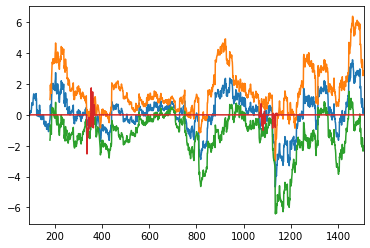

In [191]:
c.spread_df['NKE_XLY'].plot()
std=c.spread_df['NKE_XLY'].rolling(90).std()
(c.spread_df['NKE_XLY']+2*std).plot()
(c.spread_df['NKE_XLY']-2*std).plot()
c.PL_df['NKE_XLY'].plot()

In [207]:
c.Summary_df.filter(regex=Sector).loc['SD of ret',:].mean()


0.11163385115646836

In [206]:
c.Sector_Summary_df.loc['SD of ret',Sector]

nan

In [205]:
Sector='XLY'
c.Sharpe_ratio(c.Sector_Summary_df.loc['CAGR',Sector],c.Sector_Summary_df.loc['SD of ret',Sector])

nan

In [64]:
cumsum_ret=c.PL_df['AAPL_XLY'].cumsum()
x=(np.maximum.accumulate(cumsum_ret)-cumsum_ret).max()/np.maximum.accumulate(cumsum_ret).max()
x

0.9196976202452293

In [47]:
c.PL_df['AAPL_XLY'].cumsum().to_csv('test.csv')

C:\Users\runmi\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


In [21]:
c.Summary_df.to_csv('Single_pair.csv')

In [181]:
pairs='NKE_XLY'
c.PL_df[pairs].to_csv('aapol.csv')

C:\Users\pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


In [ ]:
# Final PL
x=c.PL_df.rolling()
x.iloc[-1,:].sum()

In [ ]:
ta.ema(X,9).loc[119]

In [ ]:
# get the ETF name from spreads
df.loc[0,'AAPL_XLY']

In [ ]:
c.Summary_df.loc['CAGR'].sum()

In [ ]:
c.in_Sample_Dict['Tech']

In [ ]:
'Tech' in c.in_Sample_Dict.keys()

### Graphical check
##### see if the spread is truly stationary visually

In [55]:
c.spread_dict['AABA'].plot()
plt.show()

KeyError: 'AABA'

In [ ]:
x.duplicated()==False
x[x.duplicated()==False]

In [ ]:
c.Hedge_ratio()

# OLDer version

In [ ]:
class backtesterV3(Import_data):
    def __init__(self,start='2008-01-01',end='2014-12-31',CSV=0,test_len=254,lookback=90,Conf_int='5%',period=20,max_universe_size=10,rolling_period=14):
        super().__init__(start=start,end=end,CSV=CSV,max_universe_size=max_universe_size)
        self.lookback=lookback
        self.Universe_Dict={}
        self.test_len=test_len
        self.in_Sample_Dict={}
        self.out_Sample_Dict={}
        self.Conf_int=Conf_int
        self.Make_Universe()
        self.period=period
        self.Model_dict={}
        self.Coint_dict={}
        self.rolling_period=rolling_period
    def Make_Universe(self):
        for Sector in self.Database.keys():
            Temp_df=pd.DataFrame()
            for Stock in self.Sector_Dict[Sector]:
                print(Stock)
                Stock_df=pd.DataFrame({Stock:self.Database[Sector][Stock]['Adj Close']})
                print(Sector)

                
                Temp_df=pd.concat([Temp_df,Stock_df],axis=1)
            
        
          
            Temp_df=Temp_df.loc[:,~Temp_df.columns.duplicated()]
         
            #c.in_Sample_Dict['Service'].loc[:,~c.in_Sample_Dict['Service'].columns.duplicated()]
            self.in_Sample_Dict[Sector]=Temp_df.dropna().iloc[:-self.test_len,:]
            self.out_Sample_Dict[Sector]=Temp_df.dropna().iloc[-self.test_len:,:]
            
    def Johansen_test(self):

    # get slope of the y=mx+c where c is the spread between 
        endog=self.in_Sample_Dict['Tech'].iloc[:,:-1]
        det_order=0
        k_ar_diff=1
        self.result=coint_johansen(endog, det_order, k_ar_diff)
    
    
    # to get the Hedge ratio between each stock and the 'ETF' of the universe    
    # Start is the day to calculate the lookback period to
    def Hedge_ratio(self,Start=300):
        self.spread_dict={}
        for Sector in self.Database.keys():
            Temp_df=pd.DataFrame()
            for Stock in self.Sector_Dict[Sector]:
                # dont do the spread if it is ETF itself
                if Stock!=self.Sector_Dict[Sector][-1]:
                    ETF=self.in_Sample_Dict[Sector].columns[-1]
                    Data1=self.in_Sample_Dict[Sector][Stock].iloc[Start-self.lookback:Start]
                    Data2=self.in_Sample_Dict[Sector].iloc[Start-self.lookback:Start,-1]
            
                    model = OLS(Data1,Data2)
                    model = model.fit()  
                    self.Model_dict[Stock]=model
                    self.Spread(Data1,Data2,model,Stock,ETF,Sector,Hedge=1)
                    
        # Pickle it up
        P.save_obj(self.Model_dict,'Model')
    def Spread(self,Data1,Data2,model,Stock,ETF,Sector,Hedge=0):
        try:
            spread=Data1 - model.params[0]* Data2

        except ValueError:
            print(Sector)
            print(Stock)

        if Hedge==1:
            ADF=self.ADF_test(spread)
            # if the ADF passed the confidence interval
            # this will filter out the stocks currently not cointegrated
            if ADF==1:
                self.Coint_dict[Stock]=(ETF,Sector)
        else:
            return spread
    def ADF_test(self,spread):
        # Compute ADF test statistics
        adf = adfuller(spread, maxlag = 1)
        
        if adf[0]<adf[4][self.Conf_int]:
            return 1
        else:
            return 0
            
    def Backtesting(self):
        
        for Row in tqdm(range(self.lookback,self.in_Sample_Dict[list(self.in_Sample_Dict.keys())[0]].shape[0])):
            # run the Model fitting once per month
            if (Row-self.lookback)%27==0:
                self.Hedge_ratio(Row)
                self.spread_dict={}
            for Stock,value in (self.Coint_dict.items()):

                # the value is in this format
                # (ETF,Sector)
                Sector=value[1]
                ETF=value[0]
                Data1=self.in_Sample_Dict[Sector][Stock].iloc[Row]
                Data2=self.in_Sample_Dict[Sector][ETF].iloc[Row]
                model=self.Model_dict[Stock]


                #return the spread of the day
                spread=self.Spread(Data1,Data2,model,Stock,ETF,Sector)
                if Stock in self.spread_dict.keys():
                    self.spread_dict[Stock].append(spread)
                else:
                    self.spread_dict[Stock]=[spread]
        
                 
    # set up the upper band n lower band Z*SD away
    def Bands(self):
        for Stock in self.spread_dict.keys():
            pass
        pass


In [ ]:
class backtesterV2(Import_data):
    def __init__(self,start='2008-01-01',end='2014-12-31',CSV=0,test_len=254,lookback=90,Conf_int='5%',period=20):
        super().__init__(start=start,end=end,CSV=CSV)
        self.lookback=lookback
        self.Universe_Dict={}
        self.test_len=test_len
        self.in_Sample_Dict={}
        self.out_Sample_Dict={}
        self.Conf_int=Conf_int
        self.Make_Universe()
        self.period=period
    def Make_Universe(self):
        for Sector in self.Database.keys():
            Temp_df=pd.DataFrame()
            for Stock in self.Sector_Dict[Sector]:
                print(Stock)
                Stock_df=pd.DataFrame({Stock:self.Database[Sector][Stock]['Adj Close']})
                print(Sector)

                
                Temp_df=pd.concat([Temp_df,Stock_df],axis=1)
            
            # make a ETF with equal weightage of all the shares in the list
            Temp_df['ETF']=Temp_df.sum(axis=1)
          
            Temp_df=Temp_df.loc[:,~Temp_df.columns.duplicated()]
         
            #c.in_Sample_Dict['Service'].loc[:,~c.in_Sample_Dict['Service'].columns.duplicated()]
            self.in_Sample_Dict[Sector]=Temp_df.dropna().iloc[:self.test_len,:]
            self.out_Sample_Dict[Sector]=Temp_df.dropna().iloc[self.test_len:,:]
            
    def Johansen_test(self):

    # get slope of the y=mx+c where c is the spread between 
        endog=self.in_Sample_Dict['Tech'].iloc[:,:-1]
        det_order=0
        k_ar_diff=1
        self.result=coint_johansen(endog, det_order, k_ar_diff)
    
    
    # to get the Hedge ratio between each stock and the 'ETF' of the universe    
    def Hedge_ratio(self):
        self.spread_dict={}
        for Sector in self.Database.keys():
            Temp_df=pd.DataFrame()
            for Stock in self.Sector_Dict[Sector]:
                model = OLS(self.in_Sample_Dict[Sector][Stock].iloc[-self.lookback:], self.in_Sample_Dict[Sector]['ETF'].iloc[-self.lookback:])
                model = model.fit() 
                
                try:
                    # need to separate as hedge ratio is done once every month while the spread calculation is done daily
                    spread=self.in_Sample_Dict[Sector][Stock] - model.params[0]* self.in_Sample_Dict[Sector]['ETF']
                except ValueError:
                    print(Sector)
                    print(Stock)
              
              
                ADF=self.ADF_test(spread)
                # if the ADF passed the confidence interval
                # this will filter out the stocks currently not cointegrated
                if ADF==1:
                    self.spread_dict[Stock]=spread
    def ADF_test(self,spread):
        # Compute ADF test statistics
        adf = adfuller(spread, maxlag = 1)
        
        if adf[0]<adf[4][self.Conf_int]:
            return 1
        else:
            return 0
            
    def Backtesting(self):
        pass
    
    # set up the upper band n lower band Z*SD away
    def Bands(self):
        for Stock in self.spread_dict.keys():
            pass
        pass


In [ ]:
class backtesterV1(Import_data):
    def __init__(self,start='2008-01-01',end='2014-12-31',CSV=0,test_len=254):
        super().__init__(start=start,end=end,CSV=CSV,test_len=test_len)
        self.Universe_Dict={}
    def Make_Universe(self):
        for Sector in self.in_Sample_df_dict.keys():
            Temp_df=pd.DataFrame()
            for Stock in self.Sector_Dict[Sector]:
                Stock_df=pd.DataFrame({Stock:self.in_Sample_df_dict[Sector][Stock]['Adj Close']})
     
          
                Temp_df=pd.concat([Temp_df,Stock_df],axis=1)
                
            self.Universe_Dict[Sector]=Temp_df
            
    def OLS_Modeling(self):

    # get slope of the y=mx+c where c is the spread between 
        model = sm.OLS(self.Universe_Dict, df.EWA.iloc[:90])
        model = model.fit() 

        model.params[0]
        
c=backtester(CSV=1)
c.Make_Universe()

In [ ]:
# All in-sample data will be store in Import_data.in_Sample_df_dict
# All out-sample data will be store in Import_data.out_Sample_df_dict
# Parameters
#  start - start date in string YYYY-MM-DD
#  end - last date of data in string YYYY-MM-DD
#  CSV - =1 to read from CSV,  = 0 to download data, recomended to at least download once to create the File path
#  test_len - the length of the out of sample data
class Import_dataV1():
    def __init__(self,start='2008-01-01',end='2014-12-31',CSV=0,test_len=254):
        self.test_len=test_len
        self.start=start
        self.end=end
         
        self.ETF_Dict={'Finance':'XLF'
                          ,'Tech':'XLK'
                          ,'Consumer_Goods':'X'
                          ,'Healthcare':''
                          ,'Service':''
                          }
        self.Sector_Dict={'Finance':''
                          ,'Tech':''
                          ,'Consumer_Goods':''
                          ,'Healthcare':''
                          ,'Service':''
                          }
        for sector in self.Sector_Dict.keys():
            self.Sector_Dict[sector]=(pd.read_csv(Path(r'./company_list/%s.csv'%sector))).iloc[:10,:]['Symbol']
        
        self.in_Sample_df_dict={}
        self.out_Sample_df_dict={}
        
        if CSV==0:
            self.Download_data()
        else:           
            self.Read_in_CSV()
    
    # to download data from yahoo
    # data will be stored in a nested Dictionary of sector and individual stock data
    def Download_data(self):
        for Sector in self.Sector_Dict.keys():
            # create a folder to store CSV
            self.FP=Path('./CSV_files',Sector)
            Path.mkdir(self.FP,exist_ok=True,parents=True)
            
            in_Dict={}
            out_Dict={}
            for Stock in self.Sector_Dict[Sector]:

                EOD = data.get_data_yahoo(Stock, self.start,self.end)
                in_Dict[Stock]=EOD.iloc[:-self.test_len,:]
                out_Dict[Stock]=EOD.iloc[-self.test_len:,:]
                # store the stock EOD data into a csv file
                EOD.to_csv(Path(self.FP,Stock+'.csv'))
                
                print(Stock)
              
            self.in_Sample_df_dict[Sector]=in_Dict
            self.out_Sample_df_dict[Sector]=out_Dict
    
    def Read_in_CSV(self):
        Prev_sector=''
        in_Dict={}
        out_Dict={}
        for Stock in Path('.','CSV_files').glob('**/*.csv'):

            # Reading in the CSV into a nested dictionary of Dataframe of each stock
            EOD=pd.read_csv(Stock)
            print(Stock.stem,'Data imported Successfully!')
            
            
            
            # if its the 1st
            if Prev_sector=='':
                in_Dict[Stock.stem]=EOD.iloc[:-self.test_len,:]
                out_Dict[Stock.stem]=EOD.iloc[-self.test_len:,:]
                Prev_sector=Stock.parent.stem
            elif Prev_sector!=Stock.parent.stem:
                in_Dict={}
                out_Dict={}
                in_Dict[Stock.stem]=EOD.iloc[:-self.test_len,:]
                out_Dict[Stock.stem]=EOD.iloc[-self.test_len:,:]
                Prev_sector=Stock.parent.stem
            else:
                in_Dict[Stock.stem]=EOD.iloc[:-self.test_len,:]
                out_Dict[Stock.stem]=EOD.iloc[-self.test_len:,:]
                Prev_sector=Stock.parent.stem
            self.in_Sample_df_dict[Stock.parent.stem]=in_Dict
            self.out_Sample_df_dict[Stock.parent.stem]=out_Dict
    